In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# 닉네임, 토큰 설정
os.environ["KAGGLE_USERNAME"] = 'nyahazime'
os.environ["KAGGLE_KEY"] = "71bc08d6d354a8274b1dc382ca5afb0c"

# 데이터 받기, colab에서 리눅스 명령어를 사용할때는 앞에 !가 붙습니다.
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 6.85MB/s]


In [2]:
!unzip -o titanic.zip
!rm titanic.zip
!ls -al

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
total 4500
drwxr-xr-x 12 jovyan users     384 Jun  6 14:40  .
drwsrwsr-x  1 jovyan users    4096 Jun  4 18:20  ..
-rw-r--r--  1 jovyan users   36025 Jun  5 06:04 'Accuracy 100%.ipynb'
-rw-r--r--  1 jovyan users    3258 Dec 11  2019  gender_submission.csv
drwxr-xr-x  6 jovyan users     192 Jun  5 06:07  .ipynb_checkpoints
-rw-r--r--  1 jovyan users 1200495 Jun  6 14:39 'Random Forest.ipynb'
-rw-r--r--  1 jovyan users    1523 Jun  5 06:04  result.csv
-rw-r--r--  1 jovyan users    2839 Jun  6 14:33  submission.csv
-rw-r--r--  1 jovyan users   28629 Dec 11  2019  test.csv
-rw-r--r--  1 jovyan users 1275563 May 21 07:18  Titanic.ipynb
-rw-r--r--  1 jovyan users 1976319 Jun  6 12:05 'Titanic Preprocessing and Decision Tree.ipynb'
-rw-r--r--  1 jovyan users   61194 Dec 11  2019  train.csv


In [3]:
df = pd.read_csv('./train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.loc[df['Age'].isnull(), 'Age'] = math.floor(df['Age'].mean())

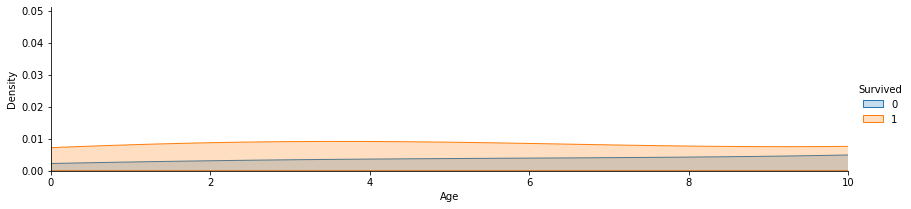

In [5]:
facet = sns.FacetGrid(df, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
sns.axes_style("darkgrid")

plt.xlim(0,10)
plt.show()

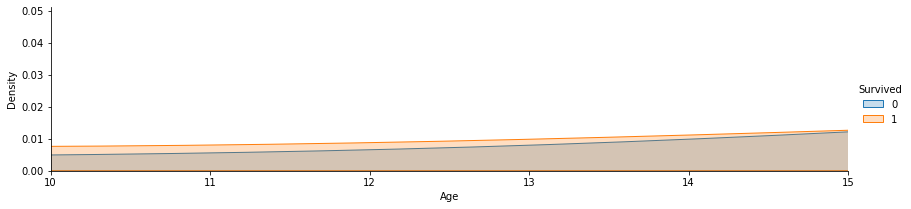

In [6]:
facet = sns.FacetGrid(df, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
sns.axes_style("darkgrid")

plt.xlim(10,15)
plt.show()

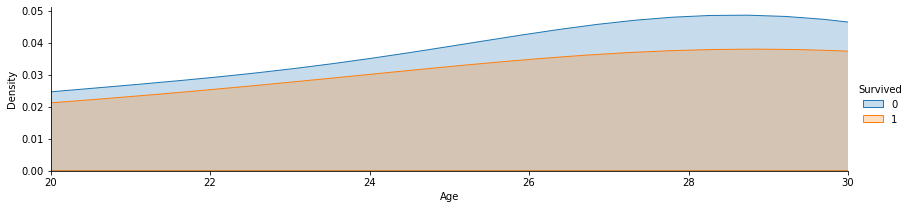

In [7]:
facet = sns.FacetGrid(df, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
sns.axes_style("darkgrid")

plt.xlim(20,30)
plt.show()

In [8]:
df.loc[ df['Age'] <= 10, 'Age_clean'] = 0
df.loc[(df['Age'] > 10) & (df['Age'] <= 16), 'Age_clean'] = 1
df.loc[(df['Age'] > 16) & (df['Age'] <= 20), 'Age_clean'] = 2
df.loc[(df['Age'] > 20) & (df['Age'] <= 26), 'Age_clean'] = 3
df.loc[(df['Age'] > 26) & (df['Age'] <= 30), 'Age_clean'] = 4
df.loc[(df['Age'] > 30) & (df['Age'] <= 36), 'Age_clean'] = 5
df.loc[(df['Age'] > 36) & (df['Age'] <= 40), 'Age_clean'] = 6
df.loc[(df['Age'] > 40) & (df['Age'] <= 46), 'Age_clean'] = 7
df.loc[(df['Age'] > 46) & (df['Age'] <= 50), 'Age_clean'] = 8
df.loc[(df['Age'] > 50) & (df['Age'] <= 60), 'Age_clean'] = 9
df.loc[ df['Age'] > 60, 'Age_clean'] = 10

<AxesSubplot:>

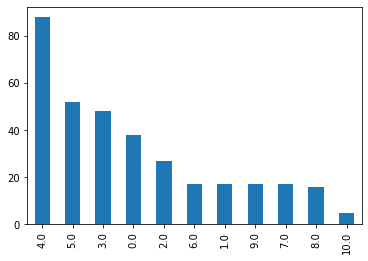

In [9]:
df[df['Survived'] == 1]['Age_clean'].value_counts().plot(kind='bar', stacked=True)

<AxesSubplot:>

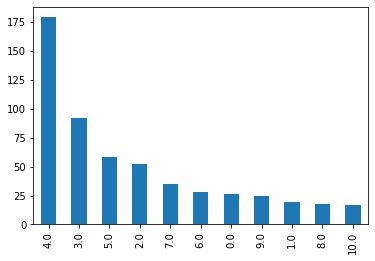

In [10]:
df[df['Survived'] == 0]['Age_clean'].value_counts().plot(kind='bar', stacked=True)

In [11]:
df['FareBin'] = pd.qcut(df['Fare'], 5)

In [12]:
df['FareBin'].value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: FareBin, dtype: int64

In [13]:
df['Fare_clean'] = df['FareBin'].astype('category').cat.codes

In [14]:
df['Fare_clean'].value_counts()

1    184
3    180
0    179
4    176
2    172
Name: Fare_clean, dtype: int64

In [15]:
scaler = MinMaxScaler()
array = df['Age'].values.reshape(-1,1)
scaler.fit(array)
df['AgeScale'] = pd.Series(scaler.transform(array).reshape(-1))

In [16]:
df['Family'] = 1 + df['SibSp'] + df['Parch']

In [17]:
df.loc[df['Embarked'].isnull(), 'Embarked'] = df['Embarked'].mode()[0]

In [18]:
df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search('Z' if pd.isna(x) else x).group())

In [19]:
df['Fare_remainder_by_10'] = df['Fare'] - (df['Fare'] % 10)
df['Age_remainder_by_10'] = df['Age'] - (df['Age'] % 10)

In [20]:
def getNameTitle(name):
    reCom = re.compile("(M(?:is)?s|(?:Mrs?))|M(?:aster)").search(name)
    if reCom is not None:
        return reCom.group()
    return 'Others'

In [21]:
df['Title'] = df['Name'].replace('Mlle', 'Miss')
df['Title'] = df['Name'].replace('Ms', 'Miss')
df['Title'] = df['Name'].replace('Mme', 'Mrs')

In [22]:
df['Name_title'] = df['Title'].map(lambda x: getNameTitle(x))

In [23]:
df['Name_title'].value_counts()

Mr        518
Miss      182
Mrs       127
Master     40
Others     23
Ms          1
Name: Name_title, dtype: int64

In [24]:
df['Fare_per_person'] = df['Fare'] / (df['SibSp'] + df['Parch'] + 1)

In [25]:
df['Fare_per_person_remainder_by_10'] = df['Fare_per_person'] - (df['Fare_per_person'] % 10)

In [26]:
df['is_alone'] = 1
df.loc[df['SibSp'] + df['Parch'] > 0, 'is_alone'] = 0

In [27]:
df['is_pclass_3_from_queenstown'] = 0
df.loc[(df['Pclass'] == 3) & (df['Embarked'] == 'Q'), 'is_pclass_3_from_queenstown'] = 1

In [28]:
df['is_pclass_3_from_southampton'] = 0
df.loc[(df['Pclass'] == 3) & (df['Embarked'] == 'S'), 'is_pclass_3_from_southampton'] = 1

In [29]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [30]:
deckDummies = pd.get_dummies(df['Deck'], prefix='Deck')
sexDummies = pd.get_dummies(df['Sex'])
embarkedDummies = pd.get_dummies(df['Embarked'])
nameTitleDummies = pd.get_dummies(df['Name_title'])

In [31]:
df = pd.concat([df, deckDummies, sexDummies, embarkedDummies, nameTitleDummies], axis=1)
df = df.drop(['Sex', 'Embarked'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,FareBin,Fare_clean,...,male,C,Q,S,Master,Miss,Mr,Mrs,Ms,Others
0,1,0,3,22.0,1,0,7.2500,3.0,"(-0.001, 7.854]",0,...,1,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,6.0,"(39.688, 512.329]",4,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,3.0,"(7.854, 10.5]",1,...,0,0,0,1,0,1,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,5.0,"(39.688, 512.329]",4,...,0,0,0,1,0,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,5.0,"(7.854, 10.5]",1,...,1,0,0,1,0,0,1,0,0,0


In [32]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_clean', 'FareBin', 'Fare_clean', 'AgeScale', 'Family', 'Deck',
       'Fare_remainder_by_10', 'Age_remainder_by_10', 'Title', 'Name_title',
       'Fare_per_person', 'Fare_per_person_remainder_by_10', 'is_alone',
       'is_pclass_3_from_queenstown', 'is_pclass_3_from_southampton', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Deck_Z', 'female', 'male', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Ms', 'Others'],
      dtype='object')

In [33]:
cols = ['Pclass', 'Fare',
        'Fare_clean', 'Fare_remainder_by_10','Fare_per_person',
       'Fare_per_person_remainder_by_10', 'is_alone', 
       'is_pclass_3_from_southampton', 
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 
       'Deck_Z', 'female', 'male', 'C', 'S', 'Miss', 'Mr',
       'Mrs']
cols = ['PassengerId',  'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_clean', 'Fare_clean', 'AgeScale', 'Family', 
       'Fare_remainder_by_10', 'Age_remainder_by_10', 
       'Fare_per_person', 'Fare_per_person_remainder_by_10', 'is_alone',
       'is_pclass_3_from_queenstown', 'is_pclass_3_from_southampton', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 
       'Deck_Z', 'female', 'male', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Ms', 'Others']

cols = [ 'Pclass', 'Age', 'Fare', 'AgeScale', 'Family',
       'Fare_per_person', 'is_pclass_3_from_southampton', 'female',
       'male', 'Miss', 'Mr', 'Mrs']

# cols = ['Pclass', 'Age', 'Fare','Family', 'Fare_per_person','is_pclass_3_from_southampton', 
#         'female', 'male', 'Miss', 'Mr', 'Mrs']
# cols = ['female', 'male']

In [34]:
dfCorr = df.corr()
dfCorr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,Fare_clean,AgeScale,...,male,C,Q,S,Master,Miss,Mr,Mrs,Ms,Others
PassengerId,1.000000,-0.005007,-0.035144,0.033632,-0.057527,-0.001652,0.012658,0.037706,-0.004906,0.033632,...,0.042939,-0.001205,-0.033606,0.022204,-0.026151,-0.073110,0.040227,0.015864,-0.000261,0.059958
Survived,-0.005007,1.000000,-0.338481,-0.067814,-0.035322,0.081629,0.257307,-0.054064,0.317783,-0.067814,...,-0.543351,0.168240,0.003650,-0.149683,0.085221,0.327093,-0.546521,0.344935,0.042470,-0.012054
Pclass,-0.035144,-0.338481,1.000000,-0.334974,0.083081,0.018443,-0.549500,-0.341465,-0.705206,-0.334974,...,0.131900,-0.243292,0.221009,0.074053,0.082081,-0.000576,0.139188,-0.158279,-0.012381,-0.187174
Age,0.033632,-0.067814,-0.334974,1.000000,-0.232978,-0.176486,0.093706,0.985721,0.116427,1.000000,...,0.082949,0.031303,-0.021093,-0.014149,-0.376027,-0.247796,0.187335,0.169894,-0.004024,0.164506
SibSp,-0.057527,-0.035322,0.083081,-0.232978,1.000000,0.414838,0.159651,-0.223713,0.354974,-0.232978,...,-0.114631,-0.059528,-0.026354,0.068734,0.349559,0.087932,-0.249598,0.062854,-0.015907,-0.038717
Parch,-0.001652,0.081629,0.018443,-0.176486,0.414838,1.000000,0.216225,-0.157569,0.351317,-0.176486,...,-0.245489,-0.011069,-0.081228,0.060814,0.267344,0.105567,-0.335107,0.221318,-0.015878,-0.059535
Fare,0.012658,0.257307,-0.549500,0.093706,0.159651,0.216225,1.000000,0.096051,0.600883,0.093706,...,-0.182333,0.269335,-0.117216,-0.162184,0.010908,0.118271,-0.182702,0.106104,-0.012961,0.022270
Age_clean,0.037706,-0.054064,-0.341465,0.985721,-0.223713,-0.157569,0.096051,1.000000,0.131689,0.985721,...,0.077639,0.023907,-0.030382,-0.001825,-0.343214,-0.250256,0.166612,0.179725,-0.002755,0.170440
Fare_clean,-0.004906,0.317783,-0.705206,0.116427,0.354974,0.351317,0.600883,0.131689,1.000000,0.116427,...,-0.244943,0.204579,-0.243154,-0.026202,0.124297,0.059106,-0.309000,0.250539,0.000266,0.096326
AgeScale,0.033632,-0.067814,-0.334974,1.000000,-0.232978,-0.176486,0.093706,0.985721,0.116427,1.000000,...,0.082949,0.031303,-0.021093,-0.014149,-0.376027,-0.247796,0.187335,0.169894,-0.004024,0.164506


<AxesSubplot:>

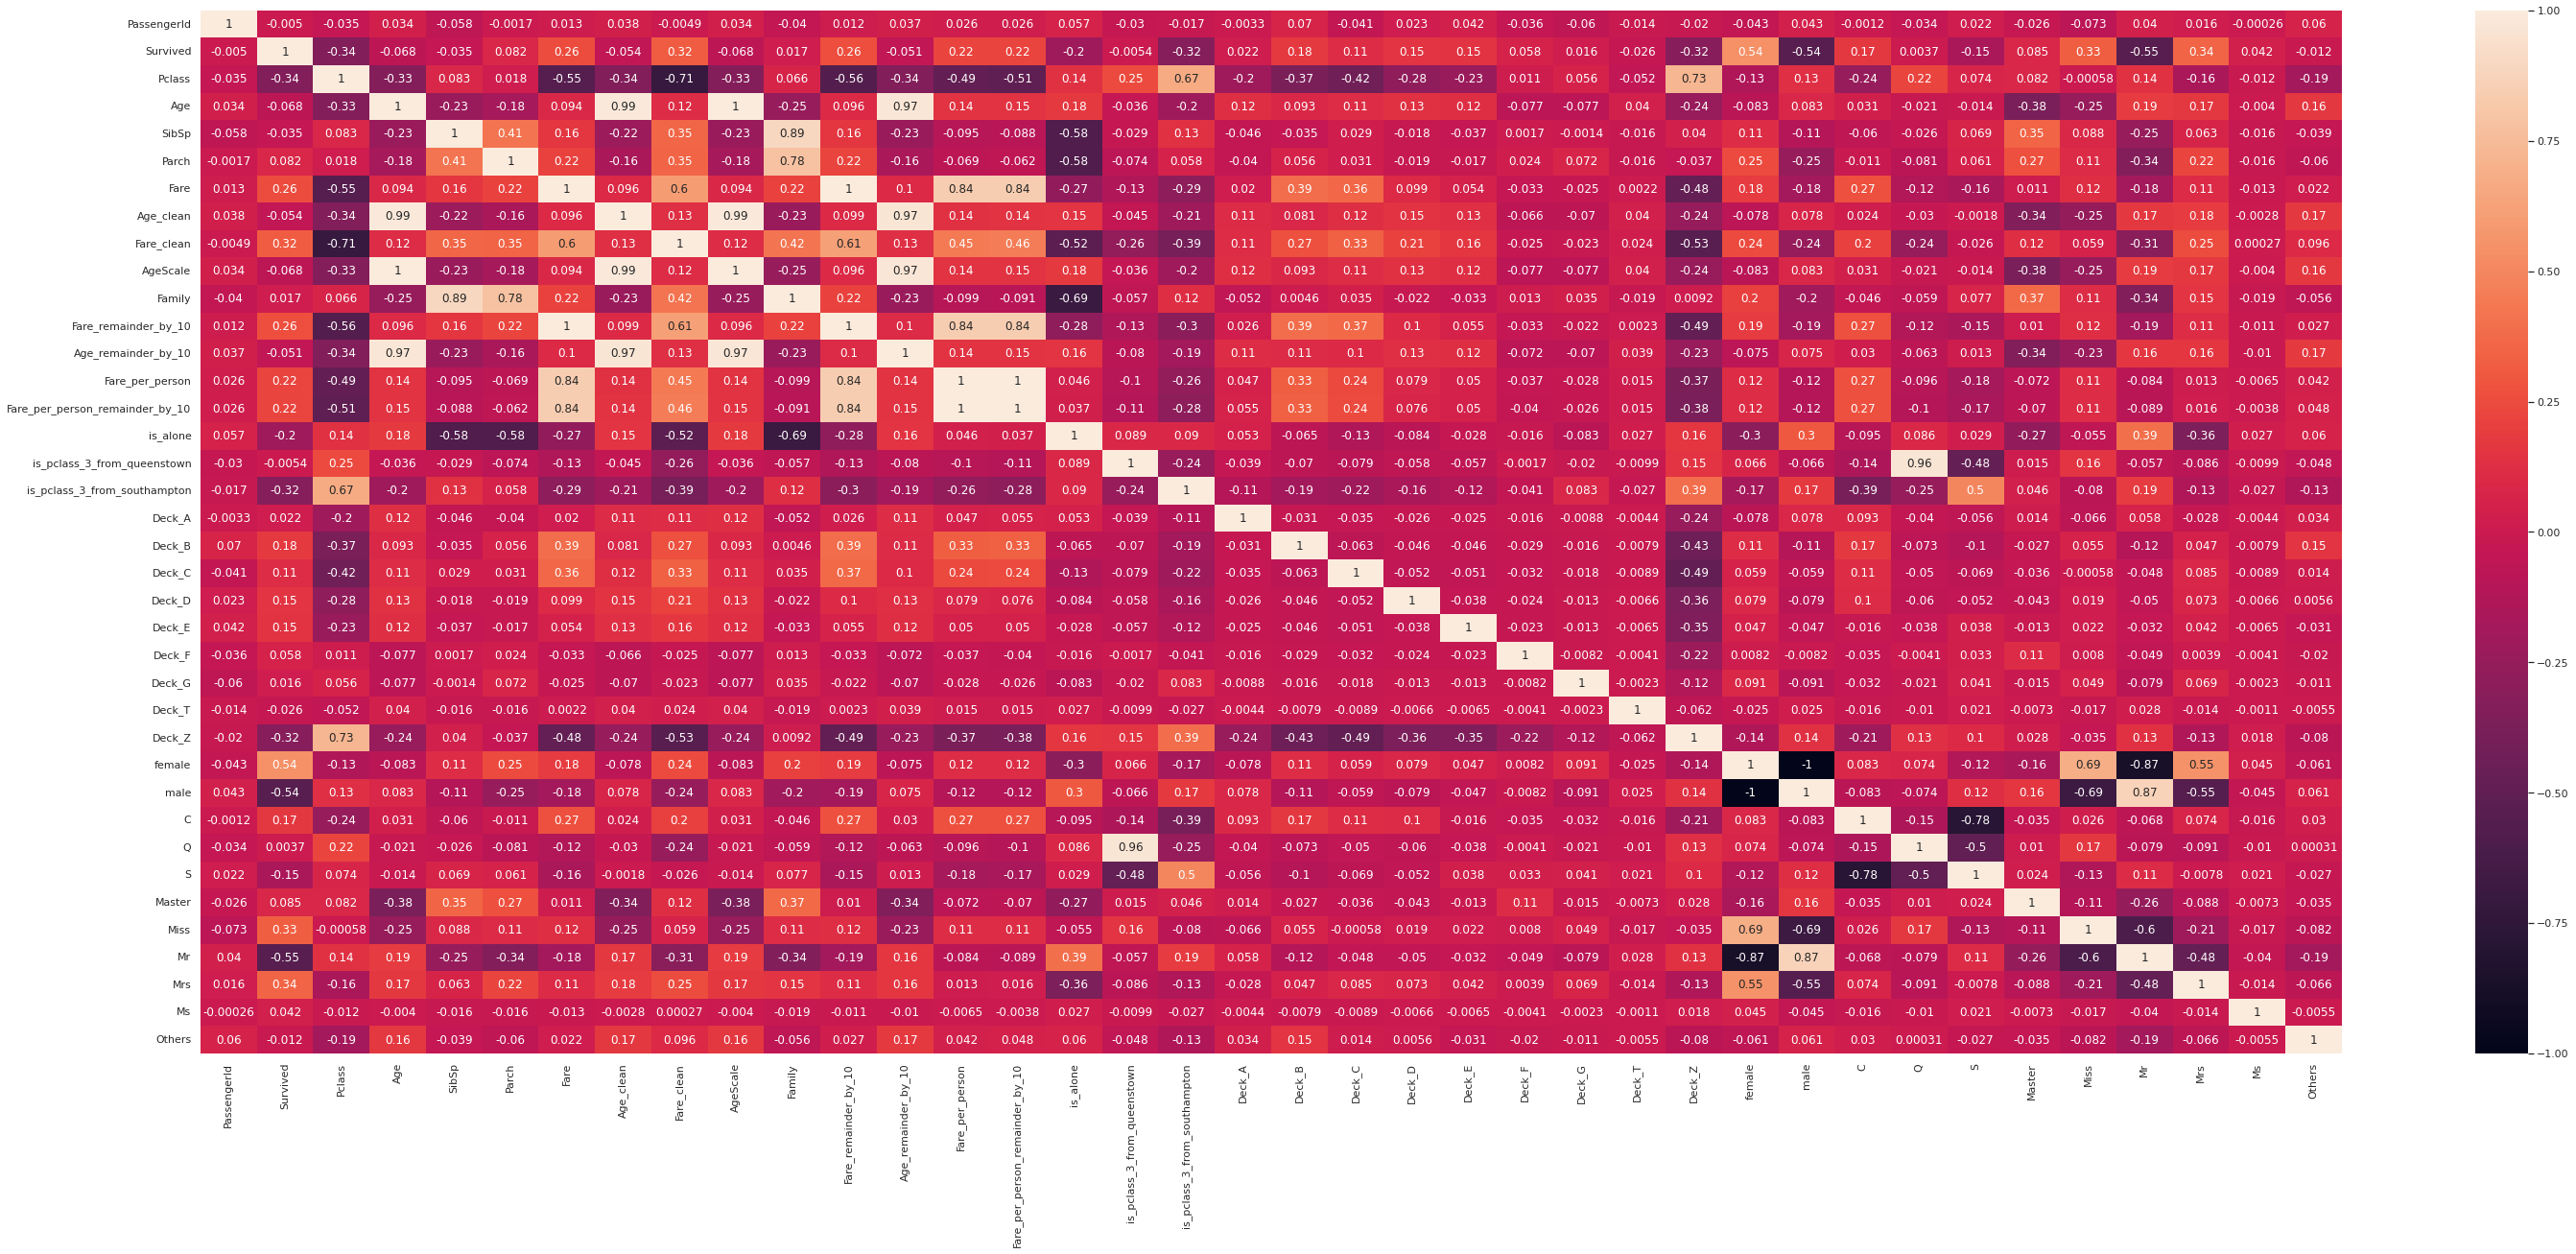

In [35]:
sns.set(rc = {'figure.figsize':(50,20)})
sns.heatmap(dfCorr, annot=True)

In [36]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [37]:
train_input, test_input, train_target, test_target = train_test_split(df[cols], df['Survived'], test_size=0.2, random_state=42)

In [38]:
train_input.head()

,Pclass,Age,Fare,AgeScale,Family,Fare_per_person,is_pclass_3_from_southampton,female,male,Miss,Mr,Mrs
331,1,45.5,28.5000,0.566474,1,28.500000,0,0,1,0,1,0
733,2,23.0,13.0000,0.283740,1,13.000000,0,0,1,0,1,0
382,3,32.0,7.9250,0.396833,1,7.925000,1,0,1,0,1,0
704,3,26.0,7.8542,0.321438,2,3.927100,1,0,1,0,1,0
813,3,6.0,31.2750,0.070118,7,4.467857,1,1,0,1,0,0


In [39]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=8, min_samples_split=20, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1, cv=5)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8774550612030957 0.8300305328474342


In [40]:
scores

{'fit_time': array([1.22102809, 1.31430411, 1.33541679, 1.3228581 , 1.34382391]),
 'score_time': array([0.11229277, 0.0778203 , 0.08174443, 0.0790534 , 0.08896947]),
 'test_score': array([0.83216783, 0.84615385, 0.81690141, 0.80985915, 0.84507042]),
 'train_score': array([0.86643234, 0.88049209, 0.88070175, 0.88070175, 0.87894737])}

In [41]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.06760529 0.06223889 0.08750465 0.06246125 0.03994997 0.10362892
 0.0605565  0.12819214 0.1721653  0.02892612 0.14668321 0.04008777]


In [42]:
rf.feature_importances_

array([0.06760529, 0.06223889, 0.08750465, 0.06246125, 0.03994997,
       0.10362892, 0.0605565 , 0.12819214, 0.1721653 , 0.02892612,
       0.14668321, 0.04008777])

In [43]:
rf.feature_importances_.mean()

0.08333333333333333

In [44]:
importancesGreaterThanMean = np.argwhere(rf.feature_importances_ > rf.feature_importances_.mean())
importancesGreaterThanMean = np.ravel(importancesGreaterThanMean)
importancesGreaterThanMean = np.array(importancesGreaterThanMean, int)
importancesGreaterThanMean
# cols[[ 0,  1,  2,  5,  8, 11, 15, 24, 25, 30, 31, 32]]
np.array(cols)[importancesGreaterThanMean]

array(['Fare', 'Fare_per_person', 'female', 'male', 'Mr'], dtype='<U28')

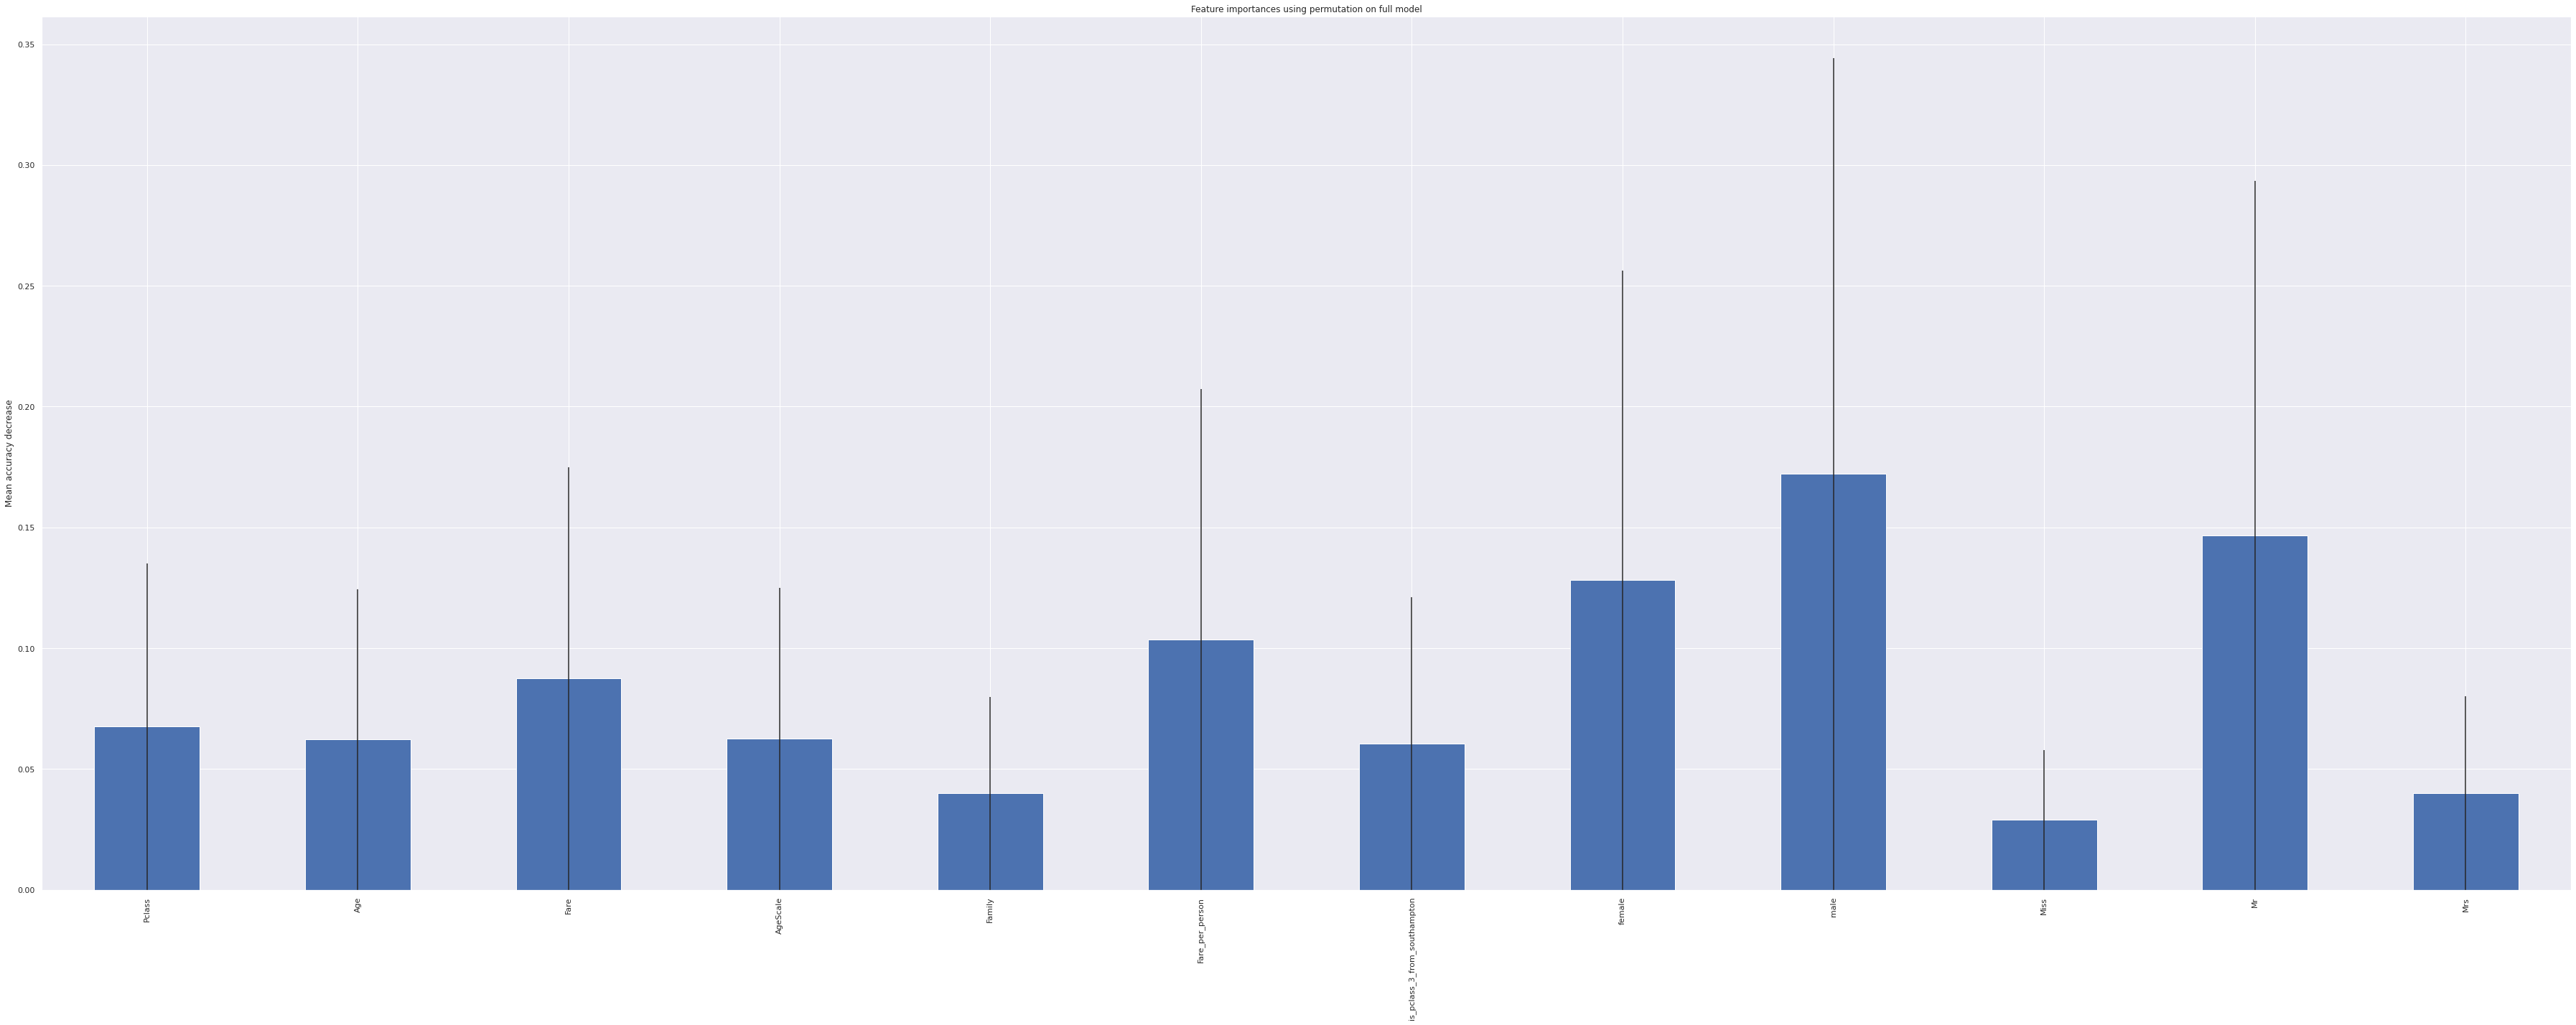

In [45]:
fig, ax = plt.subplots()
forest_importances = pd.Series(rf.feature_importances_, index=cols)
forest_importances.plot.bar(yerr=rf.feature_importances_, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [46]:
predicted = rf.predict(test_input)
accuracy = accuracy_score(test_target, predicted)

accuracy

0.8156424581005587

In [47]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [48]:
df_test.loc[df_test['Age'].isnull(), 'Age'] = math.floor(df_test['Age'].mean())
df_test.loc[df_test['Embarked'].isnull(), 'Embarked'] = df_test['Embarked'].mode()[0]
df_test['Deck'] = df_test['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search('Z' if pd.isna(x) else x).group())

df_test.loc[df_test['Fare'].isnull(), 'Fare'] = math.floor(df_test['Fare'].mean())
df_test['Fare_remainder_by_10'] = df_test['Fare'] - (df_test['Fare'] % 10)
df_test['Age_remainder_by_10'] = df_test['Age'] - (df_test['Age'] % 10)

df_test['FareBin'] = pd.qcut(df_test['Fare'], 5)
df_test['Fare_clean'] = df_test['FareBin'].astype('category').cat.codes

df_test['Family'] = 1 + df_test['SibSp'] + df_test['Parch']

df_test['Title'] = df_test['Name'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Name'].replace('Ms', 'Miss')
df_test['Title'] = df_test['Name'].replace('Mme', 'Mrs')
df_test['Name_title'] = df_test['Title'].map(lambda x: getNameTitle(x))

scaler = MinMaxScaler()
array = df_test['Age'].values.reshape(-1,1)
scaler.fit(array)
df_test['AgeScale'] = pd.Series(scaler.transform(array).reshape(-1))

df_test['Fare_per_person'] = df_test['Fare'] / (df_test['SibSp'] + df_test['Parch'] + 1)
df_test['Fare_per_person_remainder_by_10'] = df_test['Fare_per_person'] - (df_test['Fare_per_person'] % 10)
df_test['is_alone'] = 1
df_test.loc[df_test['SibSp'] + df_test['Parch'] > 0, 'is_alone'] = 0
df_test['is_pclass_3_from_queenstown'] = 0
df_test.loc[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'Q'), 'is_pclass_3_from_queenstown'] = 1
df_test['is_pclass_3_from_southampton'] = 0
df_test.loc[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'S'), 'is_pclass_3_from_southampton'] = 1
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
deckDummies = pd.get_dummies(df_test['Deck'], prefix='Deck')
sexDummies = pd.get_dummies(df_test['Sex'])
embarkedDummies = pd.get_dummies(df_test['Embarked'])
nameTitleDummies = pd.get_dummies(df_test['Name_title'])
df_test = pd.concat([df_test, deckDummies, sexDummies, embarkedDummies, nameTitleDummies], axis=1)
df_test = df_test.drop(['Sex', 'Embarked'], axis=1)

In [49]:
df_test.loc[ df_test['Age'] <= 10, 'Age_clean'] = 0
df_test.loc[(df_test['Age'] > 10) & (df_test['Age'] <= 16), 'Age_clean'] = 1
df_test.loc[(df_test['Age'] > 16) & (df_test['Age'] <= 20), 'Age_clean'] = 2
df_test.loc[(df_test['Age'] > 20) & (df_test['Age'] <= 26), 'Age_clean'] = 3
df_test.loc[(df_test['Age'] > 26) & (df_test['Age'] <= 30), 'Age_clean'] = 4
df_test.loc[(df_test['Age'] > 30) & (df_test['Age'] <= 36), 'Age_clean'] = 5
df_test.loc[(df_test['Age'] > 36) & (df_test['Age'] <= 40), 'Age_clean'] = 6
df_test.loc[(df_test['Age'] > 40) & (df_test['Age'] <= 46), 'Age_clean'] = 7
df_test.loc[(df_test['Age'] > 46) & (df_test['Age'] <= 50), 'Age_clean'] = 8
df_test.loc[(df_test['Age'] > 50) & (df_test['Age'] <= 60), 'Age_clean'] = 9
df_test.loc[ df_test['Age'] > 60, 'Age_clean'] = 10

In [50]:
predicted = rf.predict(df_test[cols])
predicted

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [51]:
predictResult = pd.DataFrame(predicted, columns = ['Survived'])
predictResult.head()

,Survived
0,0
1,0
2,0
3,0
4,1


In [52]:
predictDf = pd.concat([df_test['PassengerId'], predictResult['Survived']], axis=1)
predictDf.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [53]:
predictDf.to_csv('./submission.csv', sep=',', index = False)

In [54]:
!kaggle competitions submit -c titanic -f submission.csv -m "Random foreset"

100%|████████████████████████████████████████| 2.77k/2.77k [00:06<00:00, 453B/s]
400 - Bad Request


In [55]:
!kaggle competitions submissions -c titanic

fileName        date                 description     status    publicScore  privateScore  
--------------  -------------------  --------------  --------  -----------  ------------  
submission.csv  2022-06-06 14:33:09  Random foreset  complete  0.78947                    
submission.csv  2022-06-06 14:20:55  Random foreset  complete  0.79425                    
submission.csv  2022-06-06 14:12:35  Random foreset  complete  0.79425                    
submission.csv  2022-06-06 14:10:28  Random foreset  complete  0.79186                    
submission.csv  2022-06-06 14:10:01  Random foreset  complete  0.77033                    
submission.csv  2022-06-06 14:08:45  Random foreset  complete  0.79186                    
submission.csv  2022-06-06 13:50:56  Random foreset  complete  0.77990                    
submission.csv  2022-06-06 13:48:20  Random foreset  complete  0.79425                    
submission.csv  2022-06-06 13:43:21  Random foreset  complete  0.77990                    